# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [212]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

In [213]:
image_size = 128
autoencoder_depth = 10
dropout = 0.1
channels = 3
batch_size = 128
latent_size = 8

In [214]:
def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
dogs = idg.flow_from_directory(
    '../stanford_dogs/images/Images/', 
    target_size = (image_size, image_size), 
    batch_size = batch_size,
    color_mode = 'rgb',
    classes = ['']
)

Found 20580 images belonging to 1 classes.


## Variational Autoencoder

In [216]:
def EncoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [217]:
class VAE(keras.Model):
    def __init__(self, widths, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [219]:
vae = VAE([16, 8, 8, 8])
vae.compile(optimizer='adam')
vae.fit(dogs, epochs=100)

Encoder output shape: (None, 8, 8, 8)
Decoder output shape: (None, 128, 128, 3)
Epoch 1/100
161/161 [==============================] - 72s 441ms/step - loss: 10899.5150 - reconstruction_loss: 10539.0840 - kl_loss: 8.7914
Epoch 2/100
161/161 [==============================] - 19s 115ms/step - loss: 9857.0528 - reconstruction_loss: 9759.5850 - kl_loss: 18.2597
Epoch 3/100
161/161 [==============================] - 18s 114ms/step - loss: 9648.5596 - reconstruction_loss: 9606.0576 - kl_loss: 24.1800
Epoch 4/100
161/161 [==============================] - 19s 115ms/step - loss: 9582.7378 - reconstruction_loss: 9549.5898 - kl_loss: 24.8247
Epoch 5/100
161/161 [==============================] - 19s 115ms/step - loss: 9534.8454 - reconstruction_loss: 9511.1631 - kl_loss: 25.1864
Epoch 6/100
161/161 [==============================] - 19s 116ms/step - loss: 9513.7404 - reconstruction_loss: 9488.8027 - kl_loss: 25.2422
Epoch 7/100
161/161 [==============================] - 19s 118ms/step - loss: 9

161/161 [==============================] - 18s 113ms/step - loss: 9303.4826 - reconstruction_loss: 9271.5137 - kl_loss: 25.5356
Epoch 59/100
161/161 [==============================] - 18s 114ms/step - loss: 9300.5433 - reconstruction_loss: 9271.2559 - kl_loss: 25.6334
Epoch 60/100
161/161 [==============================] - 18s 114ms/step - loss: 9294.2442 - reconstruction_loss: 9269.6543 - kl_loss: 25.5462
Epoch 61/100
161/161 [==============================] - 19s 115ms/step - loss: 9298.5813 - reconstruction_loss: 9270.5615 - kl_loss: 25.5376
Epoch 62/100
161/161 [==============================] - 18s 114ms/step - loss: 9306.1582 - reconstruction_loss: 9269.8066 - kl_loss: 25.5024
Epoch 63/100
161/161 [==============================] - 18s 113ms/step - loss: 9298.7324 - reconstruction_loss: 9267.9814 - kl_loss: 25.5256
Epoch 64/100
161/161 [==============================] - 18s 115ms/step - loss: 9308.5293 - reconstruction_loss: 9267.9756 - kl_loss: 25.5640
Epoch 65/100
161/161 [====

In [220]:
vae.encoder.save('data/encoder2')
vae.decoder.save('data/decoder2')

INFO:tensorflow:Assets written to: data/encoder2\assets


INFO:tensorflow:Assets written to: data/encoder2\assets


INFO:tensorflow:Assets written to: data/decoder2\assets


INFO:tensorflow:Assets written to: data/decoder2\assets


In [221]:
dogs.reset()
encoded_images = vae.encode(dogs.next()[0])

for i in range(dogs.__len__()):
    next_encoded = vae.encode(dogs.next()[0])
    encoded_images = tf.concat([encoded_images, next_encoded], axis=0)

encoded_images.shape

TensorShape([20708, 8, 8, 3])

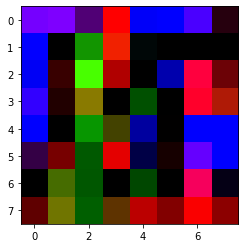

In [222]:
plt.imshow(encoded_images[0].numpy().reshape(latent_size, latent_size, channels))

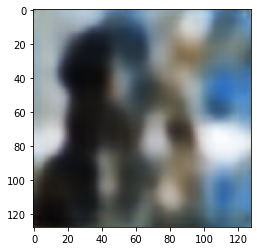

In [226]:
decoded_images = vae.decode(encoded_images[0 : 2])
plt.imshow(decoded_images[0].numpy().reshape(image_size, image_size, channels))

## Denoising U-Net

In [227]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# Architecture.
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

In [228]:
def diffusion_schedule(diffusion_times):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [229]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

In [230]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, (1, 1))(x)
            
        x = layers.Conv2D(width, (3, 3), padding='same', activation=keras.activations.swish)(x)
        x = layers.LayerNormalization()(x + residual)
        return x
    
    return apply

In [231]:
def DownBlock(width, block_depth):
    def apply(x):
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
        
    return apply

In [232]:
def UpBlock(width, block_depth):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        return x
    
    return apply

In [233]:
def create_unet(widths, block_depth):
    noisy_images = keras.Input(shape=(latent_size, latent_size, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=latent_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    for width in widths[:-1]:
        x = DownBlock(width, block_depth)(x)

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)(x)

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)
    
    unet = keras.Model([noisy_images, noise_variances], x, name="residual_unet")
    unet.compile(optimizer='adam', loss='mean_absolute_error')
    return unet

In [234]:
def train(train_data, model, epochs, batch_size):
    steps_per_epoch = int(train_data.shape[0] / batch_size)
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = train_data[step * batch_size : step * batch_size + batch_size]
            noises = tf.random.normal(shape=(batch_size, latent_size, latent_size, channels))
            
            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)
            
            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
        
        print('Epoch ' + str(epoch) + ' completed.')

In [235]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, latent_size, latent_size, channels))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2])
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [236]:
#unet = keras.models.load_model('../latent_diffusion_unet')
unet = create_unet([32, 64, 32], 4)

In [237]:
train(encoded_images, unet, 100, 2048)

Epoch 0 completed.
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.
Epoch 31 completed.
Epoch 32 completed.
Epoch 33 completed.
Epoch 34 completed.
Epoch 35 completed.
Epoch 36 completed.
Epoch 37 completed.
Epoch 38 completed.
Epoch 39 completed.
Epoch 40 completed.
Epoch 41 completed.
Epoch 42 completed.
Epoch 43 completed.
Epoch 44 completed.
Epoch 45 completed.
Epoch 46 completed.
Epoch 47 completed.
Epoch 48 completed.
Epoch 49 completed.
Epoch 50 c

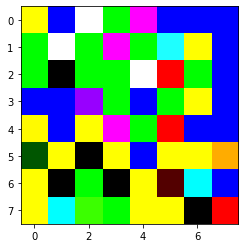

In [238]:
generated_latents = reverse_diffusion(unet, 8, 20)
plt.imshow(generated_latents[2].numpy().reshape(latent_size, latent_size, channels))

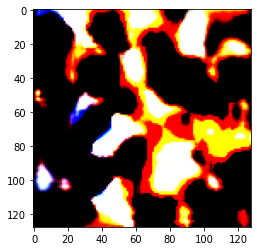

In [244]:
generated_latents = reverse_diffusion(unet, 2, 20)
generated_images = vae.decode(generated_latents)
plt.imshow(generated_images[0].numpy().reshape(image_size, image_size, channels), cmap='gray')

In [67]:
unet.save('../latent_diffusion_unet2')

INFO:tensorflow:Assets written to: ../latent_diffusion_unet2\assets


INFO:tensorflow:Assets written to: ../latent_diffusion_unet2\assets
